In [38]:
# !pip install --upgrade ta


In [39]:
from config import API_KEY
import pandas as pd,plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"
import sweetviz as sv
import plotly.express as px

from ta.trend import MACD as md
import pandas as pd
import ta
from ta.utils import dropna
import pycaret 


Obtaining Data

In [68]:
# Data Collection
from tiingo import TiingoClient
from datetime import datetime, timedelta

config = {
    'api_key': API_KEY,
    'session': True  # Use requests.Session
}
client = TiingoClient(config)

# Calculate the start date as today's date minus 2 years
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

# Convert dates to string format
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

df = client.get_dataframe('MSFT', frequency='daily',startDate=start_date_str, endDate=end_date_str)

df.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2019-02-28 00:00:00+00:00,112.03,112.88,111.73,112.04,29083934,106.623859,107.432842,106.338336,106.633377,29083934,0.0,1.0
2019-03-01 00:00:00+00:00,112.53,113.02,111.67,112.89,23501169,107.099731,107.566086,106.281232,107.442359,23501169,0.0,1.0
2019-03-04 00:00:00+00:00,112.26,113.25,110.80,113.02,26608014,106.842760,107.784987,105.453214,107.566086,26608014,0.0,1.0
2019-03-05 00:00:00+00:00,111.70,112.39,111.23,112.25,19538318,106.309784,106.966487,105.862464,106.833243,19538318,0.0,1.0
2019-03-06 00:00:00+00:00,111.75,112.66,111.43,111.87,17686996,106.357371,107.223458,106.052813,106.471580,17686996,0.0,1.0


In [41]:
df.reset_index(inplace=True)
df.rename(columns={'index': 'new_index'}, inplace=True)  # Rename the old index column
df['date'] = df['date'].dt.date  # Extract the date part from the datetime index
df

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2019-02-28,173.15,174.9100,172.92,174.32,28215416,41.671527,42.095101,41.616173,41.953108,112861664,0.0,1.0
1,2019-03-01,174.97,175.1500,172.89,174.28,25886167,42.109541,42.152861,41.608953,41.943481,103544668,0.0,1.0
2,2019-03-04,175.85,177.7500,173.97,175.69,27436203,42.321328,42.778596,41.868874,42.282822,109744812,0.0,1.0
3,2019-03-05,175.53,176.0000,174.54,175.94,19737419,42.244315,42.357428,42.006054,42.342988,78949676,0.0,1.0
4,2019-03-06,174.52,175.4900,173.94,174.67,20810384,42.001241,42.234688,41.861654,42.037341,83241536,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2024-02-21,182.32,182.8888,180.66,181.94,41529674,182.320000,182.888800,180.660000,181.940000,41529674,0.0,1.0
1254,2024-02-22,184.37,184.9550,182.46,183.48,52292208,184.370000,184.955000,182.460000,183.480000,52292208,0.0,1.0
1255,2024-02-23,182.52,185.0400,182.23,185.01,45119677,182.520000,185.040000,182.230000,185.010000,45119677,0.0,1.0
1256,2024-02-26,181.16,182.7600,180.65,182.24,40867421,181.160000,182.760000,180.650000,182.240000,40867421,0.0,1.0


Removing Columns

In [42]:
# Removing 'Dividends' and 'Stock Splits' columns
df = df.drop(['divCash', 'splitFactor','close','high','low', 'open', 'volume','adjVolume'], axis = 1)
# See results
df

,date,adjClose,adjHigh,adjLow,adjOpen
0,2019-02-28,41.671527,42.095101,41.616173,41.953108
1,2019-03-01,42.109541,42.152861,41.608953,41.943481
2,2019-03-04,42.321328,42.778596,41.868874,42.282822
3,2019-03-05,42.244315,42.357428,42.006054,42.342988
4,2019-03-06,42.001241,42.234688,41.861654,42.037341
...,...,...,...,...,...
1253,2024-02-21,182.320000,182.888800,180.660000,181.940000
1254,2024-02-22,184.370000,184.955000,182.460000,183.480000
1255,2024-02-23,182.520000,185.040000,182.230000,185.010000
1256,2024-02-26,181.160000,182.760000,180.650000,182.240000


In [43]:
# Removing NaN
df.dropna(inplace=True)
# See Results
df

,date,adjClose,adjHigh,adjLow,adjOpen
0,2019-02-28,41.671527,42.095101,41.616173,41.953108
1,2019-03-01,42.109541,42.152861,41.608953,41.943481
2,2019-03-04,42.321328,42.778596,41.868874,42.282822
3,2019-03-05,42.244315,42.357428,42.006054,42.342988
4,2019-03-06,42.001241,42.234688,41.861654,42.037341
...,...,...,...,...,...
1253,2024-02-21,182.320000,182.888800,180.660000,181.940000
1254,2024-02-22,184.370000,184.955000,182.460000,183.480000
1255,2024-02-23,182.520000,185.040000,182.230000,185.010000
1256,2024-02-26,181.160000,182.760000,180.650000,182.240000


In [44]:

# Calculate the RSI using the adjusted close column
rsi_indicator = ta.momentum.RSIIndicator(close=df['adjOpen'], window=14)
df['RSI'] = rsi_indicator.rsi()


df_diff = df.drop(columns=['RSI']).diff().dropna()


diffs = pd.concat([df_diff, df[['RSI']]], axis=1)

# Display the resulting dataframe
diffs

,date,adjClose,adjHigh,adjLow,adjOpen,RSI
1,"1 day, 0:00:00",0.438014,0.057760,-0.007220,-0.009627,NaN
2,"3 days, 0:00:00",0.211787,0.625735,0.259921,0.339341,NaN
3,"1 day, 0:00:00",-0.077014,-0.421168,0.137180,0.060167,NaN
4,"1 day, 0:00:00",-0.243074,-0.122740,-0.144400,-0.305647,NaN
5,"1 day, 0:00:00",-0.486148,-0.252701,-0.462081,-0.192534,NaN
...,...,...,...,...,...,...
1254,"1 day, 0:00:00",2.050000,2.066200,1.800000,1.540000,43.508589
1255,"1 day, 0:00:00",-1.850000,0.085000,-0.230000,1.530000,47.067603
1256,"3 days, 0:00:00",-1.360000,-2.280000,-1.580000,-2.770000,41.918559
1257,"1 day, 0:00:00",1.470000,1.162500,-1.090000,-1.140000,39.980093


In [45]:
diffs.corr()

,adjClose,adjHigh,adjLow,adjOpen,RSI
adjClose,1.000000,0.699579,0.696713,0.340857,0.103007
adjHigh,0.699579,1.000000,0.753408,0.742849,0.250669
adjLow,0.696713,0.753408,1.000000,0.742892,0.231274
adjOpen,0.340857,0.742849,0.742892,1.000000,0.314455
RSI,0.103007,0.250669,0.231274,0.314455,1.000000


In [46]:

# Create a lag feature to represent the previous values
for i in range(1, 6):  # Assuming you want to use the first 15 points to predict the next one
    diffs[f'adjCloseLag_{i}'] = diffs['adjClose'].shift(i)
    diffs[f'adjHighlag_{i}'] = diffs['adjHigh'].shift(i)
    diffs[f'adjLowlag_{i}'] = diffs['adjLow'].shift(i)
    diffs[f'adjOpenlag_{i}'] = diffs['adjOpen'].shift(i)



In [47]:
diffs.head(10)

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,...,adjLowlag_3,adjOpenlag_3,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5
1,"1 day, 0:00:00",0.438014,0.057760,-0.007220,-0.009627,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"3 days, 0:00:00",0.211787,0.625735,0.259921,0.339341,NaN,0.438014,0.057760,-0.007220,-0.009627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"1 day, 0:00:00",-0.077014,-0.421168,0.137180,0.060167,NaN,0.211787,0.625735,0.259921,0.339341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"1 day, 0:00:00",-0.243074,-0.122740,-0.144400,-0.305647,NaN,-0.077014,-0.421168,0.137180,0.060167,...,-0.007220,-0.009627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"1 day, 0:00:00",-0.486148,-0.252701,-0.462081,-0.192534,NaN,-0.243074,-0.122740,-0.144400,-0.305647,...,0.259921,0.339341,0.438014,0.057760,-0.007220,-0.009627,NaN,NaN,NaN,NaN
6,"1 day, 0:00:00",0.098674,-0.329714,-0.606481,-0.854369,NaN,-0.486148,-0.252701,-0.462081,-0.192534,...,0.137180,0.060167,0.211787,0.625735,0.259921,0.339341,0.438014,0.057760,-0.007220,-0.009627
7,"3 days, 0:00:00",1.441597,1.456037,1.407903,1.244249,NaN,0.098674,-0.329714,-0.606481,-0.854369,...,-0.144400,-0.305647,-0.077014,-0.421168,0.137180,0.060167,0.211787,0.625735,0.259921,0.339341
8,"1 day, 0:00:00",0.483741,0.854369,0.967482,1.085409,NaN,1.441597,1.456037,1.407903,1.244249,...,-0.462081,-0.192534,-0.243074,-0.122740,-0.144400,-0.305647,-0.077014,-0.421168,0.137180,0.060167
9,"1 day, 0:00:00",0.192534,0.151620,0.373034,0.541501,NaN,0.483741,0.854369,0.967482,1.085409,...,-0.606481,-0.854369,-0.486148,-0.252701,-0.462081,-0.192534,-0.243074,-0.122740,-0.144400,-0.305647
10,"1 day, 0:00:00",0.486148,0.192534,0.394694,0.397101,NaN,0.192534,0.151620,0.373034,0.541501,...,1.407903,1.244249,0.098674,-0.329714,-0.606481,-0.854369,-0.486148,-0.252701,-0.462081,-0.192534


In [48]:
diffs['date'] = df['date']
diffs

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,...,adjLowlag_3,adjOpenlag_3,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5
1,2019-03-01,0.438014,0.057760,-0.007220,-0.009627,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-03-04,0.211787,0.625735,0.259921,0.339341,NaN,0.438014,0.057760,-0.007220,-0.009627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-03-05,-0.077014,-0.421168,0.137180,0.060167,NaN,0.211787,0.625735,0.259921,0.339341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-03-06,-0.243074,-0.122740,-0.144400,-0.305647,NaN,-0.077014,-0.421168,0.137180,0.060167,...,-0.007220,-0.009627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-03-07,-0.486148,-0.252701,-0.462081,-0.192534,NaN,-0.243074,-0.122740,-0.144400,-0.305647,...,0.259921,0.339341,0.438014,0.05776,-0.00722,-0.009627,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2024-02-22,2.050000,2.066200,1.800000,1.540000,43.508589,0.760000,0.458800,0.660000,0.150000,...,0.315000,-0.130000,-0.290000,-1.04000,-1.09000,-1.770000,-0.89,-0.6800,-1.0728,-0.45
1255,2024-02-23,-1.850000,0.085000,-0.230000,1.530000,47.067603,2.050000,2.066200,1.800000,1.540000,...,-1.665000,-1.630000,-1.550000,0.36000,0.31500,-0.130000,-0.29,-1.0400,-1.0900,-1.77
1256,2024-02-26,-1.360000,-2.280000,-1.580000,-2.770000,41.918559,-1.850000,0.085000,-0.230000,1.530000,...,0.660000,0.150000,-0.750000,-2.42000,-1.66500,-1.630000,-1.55,0.3600,0.3150,-0.13
1257,2024-02-27,1.470000,1.162500,-1.090000,-1.140000,39.980093,-1.360000,-2.280000,-1.580000,-2.770000,...,1.800000,1.540000,0.760000,0.45880,0.66000,0.150000,-0.75,-2.4200,-1.6650,-1.63


In [49]:
diffs = diffs.drop(0)
diffs

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,...,adjLowlag_3,adjOpenlag_3,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5
1,2019-03-01,0.438014,0.057760,-0.007220,-0.009627,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-03-04,0.211787,0.625735,0.259921,0.339341,NaN,0.438014,0.057760,-0.007220,-0.009627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-03-05,-0.077014,-0.421168,0.137180,0.060167,NaN,0.211787,0.625735,0.259921,0.339341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-03-06,-0.243074,-0.122740,-0.144400,-0.305647,NaN,-0.077014,-0.421168,0.137180,0.060167,...,-0.007220,-0.009627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-03-07,-0.486148,-0.252701,-0.462081,-0.192534,NaN,-0.243074,-0.122740,-0.144400,-0.305647,...,0.259921,0.339341,0.438014,0.05776,-0.00722,-0.009627,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2024-02-21,0.760000,0.458800,0.660000,0.150000,39.720480,-0.750000,-2.420000,-1.665000,-1.630000,...,-1.090000,-1.770000,-0.890000,-0.68000,-1.07280,-0.450000,-2.11,-2.46,-3.2772,-2.645
1254,2024-02-22,2.050000,2.066200,1.800000,1.540000,43.508589,0.760000,0.458800,0.660000,0.150000,...,0.315000,-0.130000,-0.290000,-1.04000,-1.09000,-1.770000,-0.89,-0.68,-1.0728,-0.450
1255,2024-02-23,-1.850000,0.085000,-0.230000,1.530000,47.067603,2.050000,2.066200,1.800000,1.540000,...,-1.665000,-1.630000,-1.550000,0.36000,0.31500,-0.130000,-0.29,-1.04,-1.0900,-1.770
1256,2024-02-26,-1.360000,-2.280000,-1.580000,-2.770000,41.918559,-1.850000,0.085000,-0.230000,1.530000,...,0.660000,0.150000,-0.750000,-2.42000,-1.66500,-1.630000,-1.55,0.36,0.3150,-0.130


In [50]:
diffs.dropna()

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,...,adjLowlag_3,adjOpenlag_3,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5
13,2019-03-19,-0.358594,0.144400,0.031287,0.613701,81.725060,0.457268,0.255107,0.493368,0.228634,...,0.394694,0.397101,0.192534,0.151620,0.373034,0.541501,0.483741,0.854369,0.967482,1.085409
14,2019-03-20,0.392288,0.120334,-0.286394,-0.510214,72.359677,-0.358594,0.144400,0.031287,0.613701,...,0.283987,0.228634,0.486148,0.192534,0.394694,0.397101,0.192534,0.151620,0.373034,0.541501
15,2019-03-21,1.667824,1.646164,1.222589,0.912129,77.355632,0.392288,0.120334,-0.286394,-0.510214,...,0.493368,0.228634,0.575195,0.777355,0.283987,0.228634,0.486148,0.192534,0.394694,0.397101
16,2019-03-22,-0.972296,0.327307,0.233447,1.280350,82.215058,1.667824,1.646164,1.222589,0.912129,...,0.031287,0.613701,0.457268,0.255107,0.493368,0.228634,0.575195,0.777355,0.283987,0.228634
17,2019-03-25,-0.555941,-1.374210,-1.005989,-0.921755,70.487475,-0.972296,0.327307,0.233447,1.280350,...,-0.286394,-0.510214,-0.358594,0.144400,0.031287,0.613701,0.457268,0.255107,0.493368,0.228634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2024-02-21,0.760000,0.458800,0.660000,0.150000,39.720480,-0.750000,-2.420000,-1.665000,-1.630000,...,-1.090000,-1.770000,-0.890000,-0.680000,-1.072800,-0.450000,-2.110000,-2.460000,-3.277200,-2.645000
1254,2024-02-22,2.050000,2.066200,1.800000,1.540000,43.508589,0.760000,0.458800,0.660000,0.150000,...,0.315000,-0.130000,-0.290000,-1.040000,-1.090000,-1.770000,-0.890000,-0.680000,-1.072800,-0.450000
1255,2024-02-23,-1.850000,0.085000,-0.230000,1.530000,47.067603,2.050000,2.066200,1.800000,1.540000,...,-1.665000,-1.630000,-1.550000,0.360000,0.315000,-0.130000,-0.290000,-1.040000,-1.090000,-1.770000
1256,2024-02-26,-1.360000,-2.280000,-1.580000,-2.770000,41.918559,-1.850000,0.085000,-0.230000,1.530000,...,0.660000,0.150000,-0.750000,-2.420000,-1.665000,-1.630000,-1.550000,0.360000,0.315000,-0.130000


In [51]:
import numpy as np
diffs['target'] =np.where(diffs.adjClose >=0 ,1,0 )
diffs.head()
diffs.dropna(inplace=True)
diffs.head()

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,...,adjOpenlag_3,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5,target
13,2019-03-19,-0.358594,0.144400,0.031287,0.613701,81.725060,0.457268,0.255107,0.493368,0.228634,...,0.397101,0.192534,0.151620,0.373034,0.541501,0.483741,0.854369,0.967482,1.085409,0
14,2019-03-20,0.392288,0.120334,-0.286394,-0.510214,72.359677,-0.358594,0.144400,0.031287,0.613701,...,0.228634,0.486148,0.192534,0.394694,0.397101,0.192534,0.151620,0.373034,0.541501,1
15,2019-03-21,1.667824,1.646164,1.222589,0.912129,77.355632,0.392288,0.120334,-0.286394,-0.510214,...,0.228634,0.575195,0.777355,0.283987,0.228634,0.486148,0.192534,0.394694,0.397101,1
16,2019-03-22,-0.972296,0.327307,0.233447,1.280350,82.215058,1.667824,1.646164,1.222589,0.912129,...,0.613701,0.457268,0.255107,0.493368,0.228634,0.575195,0.777355,0.283987,0.228634,0
17,2019-03-25,-0.555941,-1.374210,-1.005989,-0.921755,70.487475,-0.972296,0.327307,0.233447,1.280350,...,-0.510214,-0.358594,0.144400,0.031287,0.613701,0.457268,0.255107,0.493368,0.228634,0


In [52]:
diffs.drop(['adjHigh', 'adjLow'],axis=1,inplace=True)
diffs.head()


,date,adjClose,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,adjCloseLag_2,adjHighlag_2,...,adjOpenlag_3,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5,target
13,2019-03-19,-0.358594,0.613701,81.725060,0.457268,0.255107,0.493368,0.228634,0.575195,0.777355,...,0.397101,0.192534,0.151620,0.373034,0.541501,0.483741,0.854369,0.967482,1.085409,0
14,2019-03-20,0.392288,-0.510214,72.359677,-0.358594,0.144400,0.031287,0.613701,0.457268,0.255107,...,0.228634,0.486148,0.192534,0.394694,0.397101,0.192534,0.151620,0.373034,0.541501,1
15,2019-03-21,1.667824,0.912129,77.355632,0.392288,0.120334,-0.286394,-0.510214,-0.358594,0.144400,...,0.228634,0.575195,0.777355,0.283987,0.228634,0.486148,0.192534,0.394694,0.397101,1
16,2019-03-22,-0.972296,1.280350,82.215058,1.667824,1.646164,1.222589,0.912129,0.392288,0.120334,...,0.613701,0.457268,0.255107,0.493368,0.228634,0.575195,0.777355,0.283987,0.228634,0
17,2019-03-25,-0.555941,-0.921755,70.487475,-0.972296,0.327307,0.233447,1.280350,1.667824,1.646164,...,-0.510214,-0.358594,0.144400,0.031287,0.613701,0.457268,0.255107,0.493368,0.228634,0


In [53]:
diffs.dropna(inplace=True)
diffs.head()

,date,adjClose,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,adjCloseLag_2,adjHighlag_2,...,adjOpenlag_3,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5,target
13,2019-03-19,-0.358594,0.613701,81.725060,0.457268,0.255107,0.493368,0.228634,0.575195,0.777355,...,0.397101,0.192534,0.151620,0.373034,0.541501,0.483741,0.854369,0.967482,1.085409,0
14,2019-03-20,0.392288,-0.510214,72.359677,-0.358594,0.144400,0.031287,0.613701,0.457268,0.255107,...,0.228634,0.486148,0.192534,0.394694,0.397101,0.192534,0.151620,0.373034,0.541501,1
15,2019-03-21,1.667824,0.912129,77.355632,0.392288,0.120334,-0.286394,-0.510214,-0.358594,0.144400,...,0.228634,0.575195,0.777355,0.283987,0.228634,0.486148,0.192534,0.394694,0.397101,1
16,2019-03-22,-0.972296,1.280350,82.215058,1.667824,1.646164,1.222589,0.912129,0.392288,0.120334,...,0.613701,0.457268,0.255107,0.493368,0.228634,0.575195,0.777355,0.283987,0.228634,0
17,2019-03-25,-0.555941,-0.921755,70.487475,-0.972296,0.327307,0.233447,1.280350,1.667824,1.646164,...,-0.510214,-0.358594,0.144400,0.031287,0.613701,0.457268,0.255107,0.493368,0.228634,0


In [54]:
from pycaret.classification import *
s = setup(diffs, target='target', fold_strategy='timeseries', ignore_features= ['adjClose', 'date', 'RSI'],session_id=123)



,Description,Value
0,Session id,123
1,Target,target
2,Target type,classification
3,Data shape,"(1245, 22)"
4,Train data shape,"(871, 22)"
5,Test data shape,"(374, 22)"
6,Ignore features,3
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


In [55]:
#  Obtaining top 3 best models
best3 = compare_models(sort = 'AUC', n_select = 3)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6215,0.6684,0.6774,0.6223,0.6451,0.2428,0.2474,0.5550
lda,Linear Discriminant Analysis,0.6101,0.6675,0.6672,0.6118,0.6352,0.2201,0.2238,0.0060
gbc,Gradient Boosting Classifier,0.5722,0.6028,0.6182,0.5816,0.5960,0.1461,0.1475,0.0510
ada,Ada Boost Classifier,0.5570,0.5918,0.6069,0.5646,0.5823,0.1114,0.1139,0.0240
xgboost,Extreme Gradient Boosting,0.5582,0.5899,0.6089,0.5719,0.5847,0.1207,0.1222,0.0400
lightgbm,Light Gradient Boosting Machine,0.5570,0.5857,0.6131,0.5675,0.5849,0.1170,0.1189,0.2920
catboost,CatBoost Classifier,0.5620,0.5814,0.6405,0.5764,0.6001,0.1297,0.1274,1.7400
rf,Random Forest Classifier,0.5570,0.5791,0.5891,0.5700,0.5741,0.1177,0.1193,0.0440
et,Extra Trees Classifier,0.5481,0.5772,0.6034,0.5632,0.5774,0.1016,0.1019,0.0350
nb,Naive Bayes,0.5468,0.5592,0.6894,0.5466,0.6083,0.0860,0.0889,0.0060


In [56]:
# Tune the top 3 models
tuned = [tune_model(best3[i],optimize='Accuracy') for i in range(3)]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5190,0.5927,0.8378,0.4921,0.6200,0.0729,0.0943
1,0.5190,0.5513,0.6316,0.5000,0.5581,0.0458,0.0473
2,0.6203,0.6077,0.6383,0.6977,0.6667,0.2275,0.2287
3,0.6076,0.6010,0.6429,0.6279,0.6353,0.2108,0.2108
4,0.6329,0.6596,0.6389,0.5897,0.6133,0.2650,0.2658
5,0.4684,0.5006,0.4750,0.4750,0.4750,-0.0635,-0.0635
6,0.5949,0.6297,0.6341,0.6047,0.6190,0.1871,0.1874
7,0.5823,0.5564,0.6667,0.5652,0.6118,0.1663,0.1690
8,0.6203,0.6316,0.6098,0.6410,0.6250,0.2409,0.2412
9,0.6582,0.7392,0.6667,0.7143,0.6897,0.3104,0.3113


In [57]:
# Create dashborad for Logistic Regression
# dashboard(tuned[0],display_format='inline')

In [58]:
# Create model
# lr = create_model('lr')



In [59]:
# Evaluate the model
evaluate_model(tuned[0])
# interpret_model(lda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [60]:
final_lr_model = finalize_model(tuned[0])


In [61]:
save_model(final_lr_model,model_name='final_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\alyss\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransfomerWrapper(include=['adjOpen', 'adjCloseLag_1', 'adjHighlag_1', 'adjLowlag_1', 'adjOpenlag_1', 'adjCloseLag_2', 'adjHighlag_2', 'adjLowlag_2', 'adjOpenlag_2', 'adjCloseLag_3', 'adjHighlag_3', 'adjLowlag_3', 'adjOpenlag_3', 'adjCloseLag_4', 'adjHighlag_4', 'adjLowlag_4', 'adjOpenlag_4', 'adjCloseLag_5', 'adjHighlag_5', 'adjLowlag_5', 'adjOpenlag_5'], transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransfomerWrapper(include=[], transformer=SimpleImputer(fill_value='constant', strategy='constant'))),
                 ['trained_model',
                  LogisticRegression(max_iter=1000, random_state=123)]]),
 'final_model.pkl')

In [77]:
predictions = pd.read_csv('predictions.csv')

In [78]:
predictions.tail(5)

,date,adjClose,adjOpen,RSI,adjCloseLag_1,adjCloseLag_2,adjCloseLag_3,adjCloseLag_4,adjCloseLag_5,adjHighlag_1,...,adjLowlag_4,adjLowlag_5,adjOpenlag_1,adjOpenlag_2,adjOpenlag_3,adjOpenlag_4,adjOpenlag_5,target,prediction_label,prediction_score
1240,2024-02-20,-1.27,-4.720,52.240910,-2.50,-2.93,3.912834,-8.923656,-5.280329,-0.84,...,-11.339232,-0.339378,-0.18,0.07,3.87031,-15.586453,5.295301,0,1,0.5568
1241,2024-02-21,-0.61,-3.070,49.344387,-1.27,-2.50,-2.930000,3.912834,-8.923656,-3.80,...,1.917477,-11.339232,-4.72,-0.18,0.07000,3.870310,-15.586453,0,0,0.6428
1242,2024-02-22,9.47,10.020,57.606316,-0.61,-1.27,-2.500000,-2.930000,3.912834,-2.20,...,-0.280000,1.917477,-3.07,-4.72,-0.18000,0.070000,3.870310,1,1,0.9581
1243,2024-02-23,-1.31,5.480,61.321815,9.47,-0.61,-1.270000,-2.500000,-2.930000,10.54,...,-0.850000,-0.280000,10.02,-3.07,-4.72000,-0.180000,0.070000,0,1,0.7450
1244,2024-02-26,-2.80,-4.215,57.171356,-1.31,9.47,-0.610000,-1.270000,-2.500000,3.03,...,-5.430000,-0.850000,5.48,10.02,-3.07000,-4.720000,-0.180000,0,0,0.5600


In [65]:
# predictions = predict_model(final_lr_model,
#                           data =diffs)
# predictions.head(5)

,adjOpen,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,adjCloseLag_2,adjHighlag_2,adjLowlag_2,adjOpenlag_2,adjCloseLag_3,...,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5,Label,Score
13,0.613701,0.457268,0.255107,0.493368,0.228634,0.575195,0.777355,0.283987,0.228634,0.486148,...,0.192534,0.151620,0.373034,0.541501,0.483741,0.854369,0.967482,1.085409,1,0.5303
14,-0.510214,-0.358594,0.144400,0.031287,0.613701,0.457268,0.255107,0.493368,0.228634,0.575195,...,0.486148,0.192534,0.394694,0.397101,0.192534,0.151620,0.373034,0.541501,1,0.5032
15,0.912129,0.392288,0.120334,-0.286394,-0.510214,-0.358594,0.144400,0.031287,0.613701,0.457268,...,0.575195,0.777355,0.283987,0.228634,0.486148,0.192534,0.394694,0.397101,1,0.5970
16,1.280350,1.667824,1.646164,1.222589,0.912129,0.392288,0.120334,-0.286394,-0.510214,-0.358594,...,0.457268,0.255107,0.493368,0.228634,0.575195,0.777355,0.283987,0.228634,1,0.5245
17,-0.921755,-0.972296,0.327307,0.233447,1.280350,1.667824,1.646164,1.222589,0.912129,0.392288,...,-0.358594,0.144400,0.031287,0.613701,0.457268,0.255107,0.493368,0.228634,1,0.5591


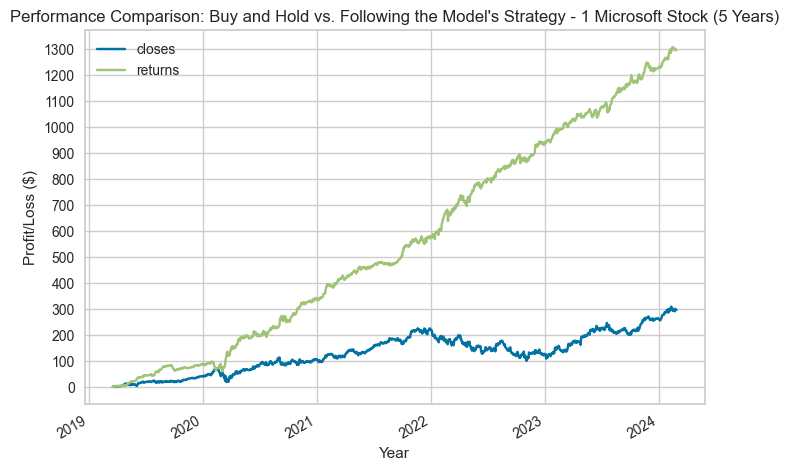

In [87]:
import matplotlib.pyplot as plt

# Create a new column 'Profit_Loss' and calculate cumulative total
predictions.set_index(pd.to_datetime(predictions['date'], format='%Y-%m-%d'), inplace=True)
predictions['rw'] = np.where(predictions['prediction_label'] == predictions['target'], 1, -1)
predictions['p_and_l'] = predictions['rw'] * (predictions['adjClose'] - predictions['adjOpen']).abs()

predictions['closes'] = predictions['adjClose'].cumsum()
predictions['returns'] = predictions.p_and_l.cumsum()
predictions[['closes', 'returns']].plot()

# Add X and Y labels
plt.xlabel('Year')
plt.ylabel('Profit/Loss ($)')

# Adjust the size of Y ticks
plt.yticks(np.arange(predictions['returns'].min(), predictions['returns'].max(), step=100))

# Add a title to the graph
plt.title("Performance Comparison: Buy and Hold vs. Following the Model's Strategy - 1 Microsoft Stock (5 Years)")

# Show the plot
plt.show()



In [ ]:


predictions['Cumulative_Total'] = predictions['p_and_l'].cumsum()
predictions.tail(10)

,date,adjClose,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,adjCloseLag_2,adjHighlag_2,...,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5,target,prediction_label,prediction_score,rw,p_and_l,Cumulative_Total
1252,2024-02-20,-1.27,-4.720,52.240910,-2.50,-0.84,-0.85,-0.180,-2.93,-0.71,...,-5.280329,-0.079854,-0.339378,5.295301,0,1,0.5984,-1,-3.450,1321.266433
1253,2024-02-21,-0.61,-3.070,49.344387,-1.27,-3.80,-5.43,-4.720,-2.50,-0.84,...,-8.923656,-10.649495,-11.339231,-15.586452,0,0,0.6097,1,2.460,1323.726433
1254,2024-02-22,9.47,10.020,57.606316,-0.61,-2.20,-0.79,-3.070,-1.27,-3.80,...,3.912833,0.518691,1.917477,3.870311,1,1,0.9648,1,0.550,1324.276433
1255,2024-02-23,-1.31,5.480,61.321815,9.47,10.54,11.35,10.020,-0.61,-2.20,...,-2.930000,-0.710000,-0.280000,0.070000,0,1,0.7792,-1,-6.790,1317.486433
1256,2024-02-26,-2.80,-4.215,57.171356,-1.31,3.03,0.40,5.480,9.47,10.54,...,-2.500000,-0.840000,-0.850000,-0.180000,0,0,0.5207,1,1.415,1318.901433
1257,2024-02-27,-0.06,-3.465,53.939312,-2.80,-3.70,-1.61,-4.215,-1.31,3.03,...,-1.270000,-3.800000,-5.430000,-4.720000,0,0,0.5171,1,3.405,1322.306433
